In [1]:
import re, time, warnings, os, sys, copy
import gzip, pickle

import numpy as np
import pandas as pd
import gzip, pickle
import scipy, sklearn, mne

import auxiliary as aux
import data, rsa
sys.path.append('../../spaces/')
import embeddings as emb
import pubplot as pub
import matplotlib.pyplot as plt

pub.styles.set()
C = pub.colours.equidistant('tab20c', k = 20)

## Supplementary Figures 10-11, Tables 9-10
This notebook produces supplementary results for single-trial EEG encoding models.

In [2]:
from subject_rerp_mt1 import load_eeg

# load sample eeg data
sub = data.Subjects['0002']
sid, pid = sub.sid, sub.pid
eeg, info = load_eeg(f'./data/preprocessed/eeg/sub{sid}/rsa-MT1-epo.fif', fs = 200)

# load invariant
with gzip.open(f'./data/results/rerp-mt1-k5-z0-s0-b0-inv-llm10.pkl.gz', 'rb') as f:
    r_inv, os_inv, ct_inv = pickle.load(f)

# load specific
with gzip.open(f'./data/results/rerp-mt1-k5-z0-s0-b0-spc-llm10.pkl.gz', 'rb') as f:
    r_spc, os_spc, ct_spc = pickle.load(f)

# load coefficients for spc
with gzip.open(f'./data/results/rerp-mt1-ko-n2-call-k5-z0-s0-b0-spc-llm10.pkl.gz', 'rb') as f:
    R2, clusters = pickle.load(f)

import matplotlib
C1 = pub.colours.equidistant('YlOrRd', k = 20)
cols_inv = [C1[5], C1[12], C1[10]]
cols_spc = [C1[7], C1[13], C1[11]]
cols_bot = [C1[9], C1[14], C1[12]]

/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_38143/1610745495.py:80: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax_col_cof.contourf(cb_x, cb_y, cb_y*wmax, vmin = -wmax, vmax = wmax, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)


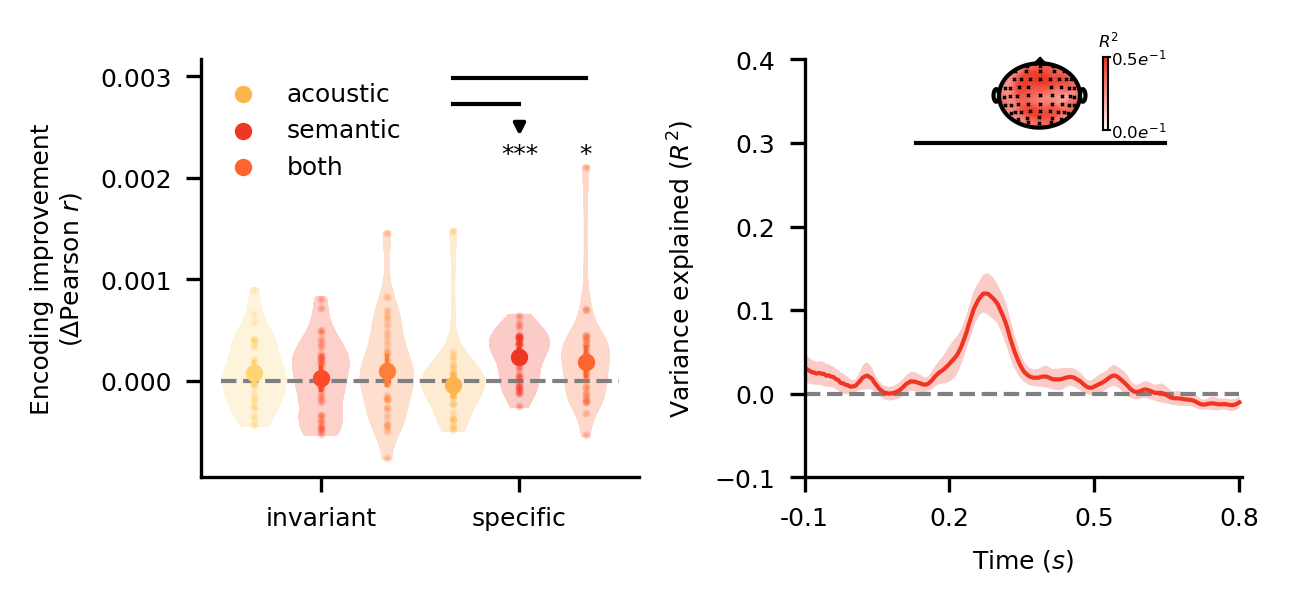

In [3]:
'''
Create figure 10
'''

fig, ax = pub.figure(nrows = 1, ncols = 2)

d_inv = r_inv[:,1:] - r_inv[:,0,None]
d_spc = r_spc[:,1:] - r_spc[:,0,None]

bw = np.array([d_inv, d_spc]).flatten()
bw = pub.dist._bandwidth_botev(bw)

ax[0].plot([-0.5, 5.5], [0, 0], color = 'gray', linestyle = '--')
pub.dist.violins(d_inv.T, colours = cols_inv, scatter_dep = False, kernel_bandwidth = bw, ax = ax[0])
pub.dist.violins(d_spc.T, labels = ['acoustic', 'semantic', 'both'], colours = cols_spc, scatter_dep = False, kernel_bandwidth = bw, ax = ax[0], offset_x = 3)

sigs = 4
diff = 0.000125

mv = d_spc[:,2].max()

for key in ct_spc:
    contrast = ct_spc[key]
    i, j = key[3:].split('-')
    i, j = int(i), int(j)
    
    pv = contrast['p_cor']
    if pv <= .05:
        if j == 0:
            sig = pub.significance.__sig_from_p(pv)
            ax[0].annotate(sig, xy = (0, 0), xytext = (i + 2, mv + diff), ha = 'center', va = 'center')
        else:
            ax[0].plot([i+2, j+2], [mv + sigs * diff, mv + sigs * diff], color = 'black')
        sigs += 1

ax[0].scatter([i + 1], [mv + 3.25 * diff], marker = 'v', s = 5, color = 'black')        
ax[0].set_xticks([1, 4], labels = ['invariant', 'specific'])
ax[0].set_ylabel('Encoding improvement\n' + r'($\Delta$Pearson $r$)')
pub.cosmetics.legend(ax = ax[0], loc = 'upper left')

ß = R2[:,:,27,:]
cluster = clusters['ß_27'][0]
chs = cluster['chs_i']
tmin, tmax = cluster['tmin'], cluster['tmax']
ß = ß[:,chs,:].mean(axis = 1)
mu = ß.mean(axis = 0)
se = rsa.stats.bootstrap_se(ß)
t = np.arange(se.shape[0])

ax[1].plot(t*0, color = 'gray', linestyle = '--')
ax[1].fill_between(t, mu - 1.96 * se, mu + 1.96 * se, edgecolor = None, facecolor = cols_spc[1], alpha = 0.25)
ax[1].plot(mu, color = cols_spc[1])
ax[1].plot([tmin, tmax], [0.3, 0.3], color = 'black')

mp = tmin + (tmax - tmin) / 2
mp = mp / 181
mp -= 0.125
ax_topo = ax[1].inset_axes([mp, 0.8, 0.25, 0.2]); ax_topo.axis('off')
w = R2[:,:,27,tmin:tmax].mean(axis = (0, 2))
from inference_rsa_rec import _plot_topo_inlay
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['black', 'white', cols_spc[1]])
_plot_topo_inlay(w, info, ax = ax_topo, sensors = False, highlight = chs, cmap = cmap)

ax_col_cof = ax[1].inset_axes([mp+0.27, 0.83, 0.01, 0.175]); ax_col_cof.axis('off')
ax_col_cof.set_xlim([0, 1])
ax_col_cof.set_ylim([0, 1])
ax_col_cof.plot([0, 1], [0, 0], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([0, 1], [1, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([0, 0], [0, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1], [0, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1.4], [0, 0], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1.4], [1, 1], color = 'black', linewidth = 0.5, clip_on = False)
wmax = w.max()
ax_col_cof.annotate(fr'${np.round(wmax*10, 1)}e^{{-1}}$', fontsize = 4, xy = (1.75, 1), xytext = (1.75, 1.0), ha = 'left', va = 'center', annotation_clip = False)
ax_col_cof.annotate(fr'$0.0e^{{-1}}$', fontsize = 4, xy = (1.75, 0.0), xytext = (1.75, 0.0), ha = 'left', va = 'center', annotation_clip = False)
ax_col_cof.annotate(r'$R^2$', fontsize = 4, xy = (1.25, 1.25), xytext = (1.25, 1.25), ha = 'center', va = 'center', annotation_clip = False)
cb_x = np.linspace(0, 1, 5)
cb_y = np.linspace(0, 1, 5)
cb_x, cb_y = np.meshgrid(cb_x, cb_y)
ax_col_cof.contourf(cb_x, cb_y, cb_y*wmax, vmin = -wmax, vmax = wmax, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)

ax[1].set_ylim([-0.1, 0.4])
ax[1].set_ylabel(r'Variance explained ($R^2$)')
ax[1].set_xlim([0, 181])
ax[1].set_xticks(np.arange(0, 181, 60))
ax[1].set_xticklabels(np.round(np.arange(-20, 161, 60)*5e-3, 2))
ax[1].set_xlabel(r'Time ($s$)')

pub.cosmetics.finish()

fig.savefig(f'./figures/png/suppfig10_enc-llm10.png', dpi = 300)
fig.savefig(f'./figures/svg/suppfig10_enc-llm10.svg')
fig.savefig(f'./figures/pdf/suppfig10_enc-llm10.pdf')


dpi = 300  # any value; inches = pixels / dpi

fig.savefig(
    f'./figures/tiff/suppfig10_enc-llm10.tiff',
    dpi=dpi,
    format="tiff",
    # needs Matplotlib >=3.7 for pil_kwargs
    pil_kwargs={"compression": "tiff_lzw"}  # or "tiff_adobe_deflate", "raw"
)

In [4]:
tmin, tmax

(46, 149)

In [5]:
'''
Generate table 9
'''

contrast = []
mu = []
sd = []
df = []
t = []
p = []

for key in ct_inv:
    i, j = key.split(' ')[1].split('-')
    i, j = int(i), int(j)
    
    ii = ['baseline', 'ac.', 'sem.', 'bth.']
    i = ii[i]
    j = ii[j]
    
    name = f'inv. {i}-{j}'
    con = ct_inv[key]
    
    contrast.append(name)
    mu.append(con['mu'])
    sd.append(con['sd'])
    df.append(con['df'])
    t.append(con['t'])
    p.append(con['p_cor'])

for key in ct_spc:
    i, j = key.split(' ')[1].split('-')
    i, j = int(i), int(j)
    
    ii = ['baseline', 'ac.', 'sem.', 'bth.']
    i = ii[i]
    j = ii[j]
    
    name = f'spc. {i}-{j}'
    con = ct_spc[key]
    
    contrast.append(name)
    mu.append(con['mu'])
    sd.append(con['sd'])
    df.append(con['df'])
    t.append(con['t'])
    p.append(con['p_cor'])

df = {'contrast': contrast, 'M': mu, 'Std. Dev.': sd, 'df': df, 't-value': t, 'p-value': p}
df = pd.DataFrame.from_dict(df)

print(df.to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
          contrast &         M &  Std. Dev. &  df &   t-value &  p-value \\
\midrule
 inv. ac.-baseline &  0.000076 &   0.000316 &  34 &  1.399752 & 1.000000 \\
inv. sem.-baseline &  0.000023 &   0.000350 &  34 &  0.376861 & 0.708619 \\
     inv. sem.-ac. & -0.000053 &   0.000508 &  34 & -0.611232 & 1.000000 \\
inv. bth.-baseline &  0.000099 &   0.000438 &  34 &  1.311878 & 0.991752 \\
     inv. bth.-ac. &  0.000023 &   0.000333 &  34 &  0.397016 & 1.000000 \\
    inv. bth.-sem. &  0.000076 &   0.000352 &  34 &  1.258929 & 0.866525 \\
 spc. ac.-baseline & -0.000040 &   0.000329 &  34 & -0.707456 & 0.968209 \\
spc. sem.-baseline &  0.000236 &   0.000230 &  34 &  5.982584 & 0.000005 \\
     spc. sem.-ac. &  0.000276 &   0.000428 &  34 &  3.754684 & 0.002601 \\
spc. bth.-baseline &  0.000188 &   0.000431 &  34 &  2.545933 & 0.046801 \\
     spc. bth.-ac. &  0.000228 &   0.000235 &  34 &  5.660051 & 0.000012 \\
    spc. bth.-sem. & -0.000048 &   0.000401 & 

/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_38143/3169806833.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index = False))


In [6]:
from subject_rerp_mt1 import load_eeg

# load sample eeg data
sub = data.Subjects['0002']
sid, pid = sub.sid, sub.pid
eeg, info = load_eeg(f'./data/preprocessed/eeg/sub{sid}/rsa-MT1-epo.fif', fs = 200)

# load invariant
with gzip.open(f'./data/results/rerp-mt1-k5-z0-s0-b0-inv-tar.pkl.gz', 'rb') as f:
    r_inv, os_inv, ct_inv = pickle.load(f)

# load specific
with gzip.open(f'./data/results/rerp-mt1-k5-z0-s0-b0-spc-tar.pkl.gz', 'rb') as f:
    r_spc, os_spc, ct_spc = pickle.load(f)

# load coefficients for spc
with gzip.open(f'./data/results/rerp-mt1-ko-n2-call-k5-z0-s0-b0-spc-tar.pkl.gz', 'rb') as f:
    R2, clusters = pickle.load(f)

import matplotlib
C1 = pub.colours.equidistant('YlOrRd', k = 20)
cols_inv = [C1[5], C1[12], C1[10]]
cols_spc = [C1[7], C1[13], C1[11]]
cols_bot = [C1[9], C1[14], C1[12]]

/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_38143/808744327.py:80: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax_col_cof.contourf(cb_x, cb_y, cb_y*wmax, vmin = -wmax, vmax = wmax, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)


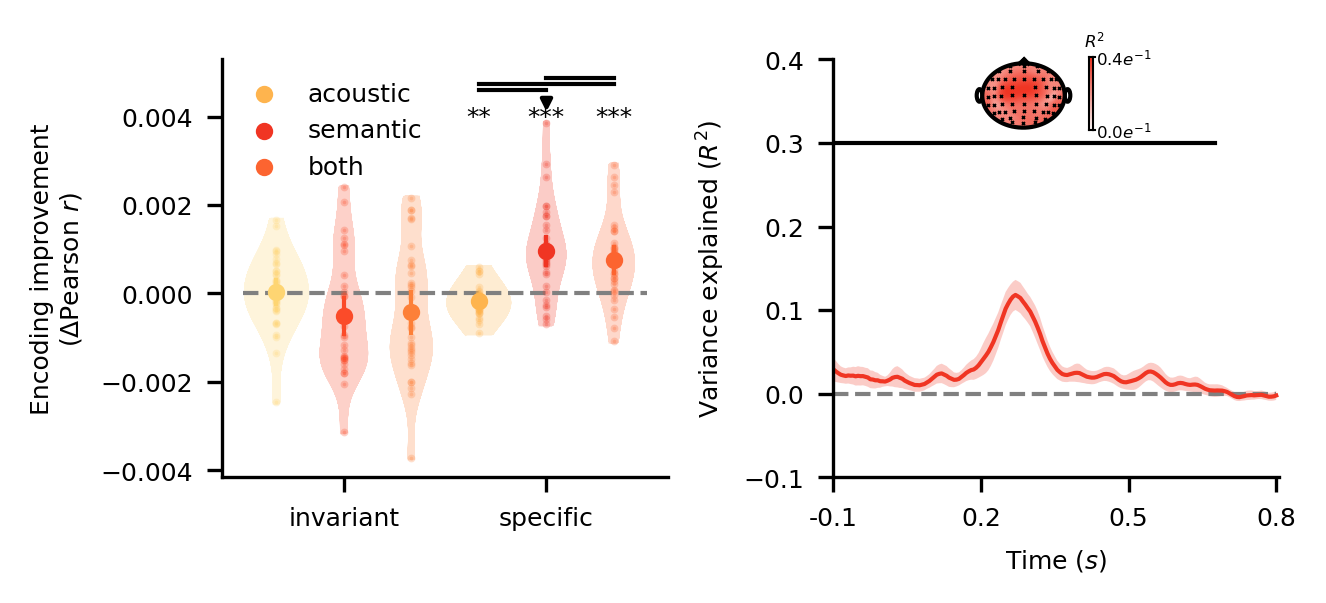

In [7]:
'''
Create figure 11
'''

fig, ax = pub.figure(nrows = 1, ncols = 2)

d_inv = r_inv[:,1:] - r_inv[:,0,None]
d_spc = r_spc[:,1:] - r_spc[:,0,None]

bw = np.array([d_inv, d_spc]).flatten()
bw = pub.dist._bandwidth_botev(bw)

ax[0].plot([-0.5, 5.5], [0, 0], color = 'gray', linestyle = '--')
pub.dist.violins(d_inv.T, colours = cols_inv, scatter_dep = False, kernel_bandwidth = bw, ax = ax[0])
pub.dist.violins(d_spc.T, labels = ['acoustic', 'semantic', 'both'], colours = cols_spc, scatter_dep = False, kernel_bandwidth = bw, ax = ax[0], offset_x = 3)

sigs = 6
diff = 0.000125

mv = d_spc.max()

for key in ct_spc:
    contrast = ct_spc[key]
    i, j = key[3:].split('-')
    i, j = int(i), int(j)
    
    pv = contrast['p_cor']
    if pv <= .05:
        if j == 0:
            sig = pub.significance.__sig_from_p(pv)
            ax[0].annotate(sig, xy = (0, 0), xytext = (i + 2, mv + diff), ha = 'center', va = 'center')
        else:
            ax[0].plot([i+2, j+2], [mv + sigs * diff, mv + sigs * diff], color = 'black')
            sigs += 1

ax[0].scatter([i + 1], [mv + 3.75 * diff], marker = 'v', s = 5, color = 'black')        
ax[0].set_xticks([1, 4], labels = ['invariant', 'specific'])
ax[0].set_ylabel('Encoding improvement\n' + r'($\Delta$Pearson $r$)')
pub.cosmetics.legend(ax = ax[0], loc = 'upper left')

ß = R2[:,:,9,:]
cluster = clusters['ß_9'][0]
chs = cluster['chs_i']
tmin, tmax = cluster['tmin'], cluster['tmax']
ß = ß[:,chs,:].mean(axis = 1)
mu = ß.mean(axis = 0)
se = rsa.stats.bootstrap_se(ß)
t = np.arange(se.shape[0])

ax[1].plot(t*0, color = 'gray', linestyle = '--')
ax[1].fill_between(t, mu - 1.96 * se, mu + 1.96 * se, edgecolor = None, facecolor = cols_spc[1], alpha = 0.25)
ax[1].plot(mu, color = cols_spc[1])
ax[1].plot([tmin, tmax], [0.3, 0.3], color = 'black')

mp = tmin + (tmax - tmin) / 2
mp = mp / 181
mp -= 0.125
ax_topo = ax[1].inset_axes([mp, 0.8, 0.25, 0.2]); ax_topo.axis('off')
w = R2[:,:,9,tmin:tmax].mean(axis = (0, 2))
from inference_rsa_rec import _plot_topo_inlay
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['black', 'white', cols_spc[1]])
_plot_topo_inlay(w, info, ax = ax_topo, sensors = False, highlight = chs, cmap = cmap)

ax_col_cof = ax[1].inset_axes([mp+0.27, 0.83, 0.01, 0.175]); ax_col_cof.axis('off')
ax_col_cof.set_xlim([0, 1])
ax_col_cof.set_ylim([0, 1])
ax_col_cof.plot([0, 1], [0, 0], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([0, 1], [1, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([0, 0], [0, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1], [0, 1], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1.4], [0, 0], color = 'black', linewidth = 0.5, clip_on = False)
ax_col_cof.plot([1, 1.4], [1, 1], color = 'black', linewidth = 0.5, clip_on = False)
wmax = w.max()
ax_col_cof.annotate(fr'${np.round(wmax*10, 1)}e^{{-1}}$', fontsize = 4, xy = (1.75, 1), xytext = (1.75, 1.0), ha = 'left', va = 'center', annotation_clip = False)
ax_col_cof.annotate(fr'$0.0e^{{-1}}$', fontsize = 4, xy = (1.75, 0.0), xytext = (1.75, 0.0), ha = 'left', va = 'center', annotation_clip = False)
ax_col_cof.annotate(r'$R^2$', fontsize = 4, xy = (1.25, 1.25), xytext = (1.25, 1.25), ha = 'center', va = 'center', annotation_clip = False)
cb_x = np.linspace(0, 1, 5)
cb_y = np.linspace(0, 1, 5)
cb_x, cb_y = np.meshgrid(cb_x, cb_y)
ax_col_cof.contourf(cb_x, cb_y, cb_y*wmax, vmin = -wmax, vmax = wmax, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)

ax[1].set_ylim([-0.1, 0.4])
ax[1].set_ylabel(r'Variance explained ($R^2$)')
ax[1].set_xlim([0, 181])
ax[1].set_xticks(np.arange(0, 181, 60))
ax[1].set_xticklabels(np.round(np.arange(-20, 161, 60)*5e-3, 2))
ax[1].set_xlabel(r'Time ($s$)')

pub.cosmetics.finish()

fig.savefig(f'./figures/png/suppfig11_enc-tar.png', dpi = 300)
fig.savefig(f'./figures/svg/suppfig11_enc-tar.svg')
fig.savefig(f'./figures/pdf/suppfig11_enc-tar.pdf')


dpi = 300  # any value; inches = pixels / dpi

fig.savefig(
    f'./figures/tiff/suppfig11_enc-tar.tiff',
    dpi=dpi,
    format="tiff",
    # needs Matplotlib >=3.7 for pil_kwargs
    pil_kwargs={"compression": "tiff_lzw"}  # or "tiff_adobe_deflate", "raw"
)

In [8]:
tmin, tmax

(0, 155)

In [9]:
'''
Generate table 10
'''

contrast = []
mu = []
sd = []
df = []
t = []
p = []

for key in ct_inv:
    i, j = key.split(' ')[1].split('-')
    i, j = int(i), int(j)
    
    ii = ['baseline', 'ac.', 'sem.', 'bth.']
    i = ii[i]
    j = ii[j]
    
    name = f'inv. {i}-{j}'
    con = ct_inv[key]
    
    contrast.append(name)
    mu.append(con['mu'])
    sd.append(con['sd'])
    df.append(con['df'])
    t.append(con['t'])
    p.append(con['p_cor'])

for key in ct_spc:
    i, j = key.split(' ')[1].split('-')
    i, j = int(i), int(j)
    
    ii = ['baseline', 'ac.', 'sem.', 'bth.']
    i = ii[i]
    j = ii[j]
    
    name = f'spc. {i}-{j}'
    con = ct_spc[key]
    
    contrast.append(name)
    mu.append(con['mu'])
    sd.append(con['sd'])
    df.append(con['df'])
    t.append(con['t'])
    p.append(con['p_cor'])

df = {'contrast': contrast, 'M': mu, 'Std. Dev.': sd, 'df': df, 't-value': t, 'p-value': p}
df = pd.DataFrame.from_dict(df)

print(df.to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
          contrast &         M &  Std. Dev. &  df &   t-value &  p-value \\
\midrule
 inv. ac.-baseline &  0.000026 &   0.000799 &  34 &  0.191701 & 0.849117 \\
inv. sem.-baseline & -0.000517 &   0.001237 &  34 & -2.439485 & 0.080313 \\
     inv. sem.-ac. & -0.000544 &   0.001274 &  34 & -2.488849 & 0.107237 \\
inv. bth.-baseline & -0.000431 &   0.001368 &  34 & -1.838238 & 0.224332 \\
     inv. bth.-ac. & -0.000458 &   0.001081 &  34 & -2.469447 & 0.093559 \\
    inv. bth.-sem. &  0.000086 &   0.000711 &  34 &  0.705434 & 0.970692 \\
 spc. ac.-baseline & -0.000175 &   0.000327 &  34 & -3.116407 & 0.003709 \\
spc. sem.-baseline &  0.000961 &   0.000985 &  34 &  5.687480 & 0.000009 \\
     spc. sem.-ac. &  0.001136 &   0.001106 &  34 &  5.989475 & 0.000005 \\
spc. bth.-baseline &  0.000760 &   0.000896 &  34 &  4.947531 & 0.000060 \\
     spc. bth.-ac. &  0.000935 &   0.000943 &  34 &  5.778516 & 0.000008 \\
    spc. bth.-sem. & -0.000201 &   0.000314 & 

/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_38143/2110002877.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index = False))
